In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

import json 


from sklearn.metrics import accuracy_score, log_loss, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import parallel_backend
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from pandas.tools.plotting import scatter_matrix

Using TensorFlow backend.


In [2]:
df = pd.read_csv('robot_data/train_data.csv')

In [3]:
df.drop(columns=['year'], inplace=True)

## Shuffle dataset 

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,robot_gear_compression_diff_10,...,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,13.993658,15.112167,14.456684,-3.248753,9.298614,9.485177,12.886764,6.003205,-31.818638,28.736916,...,3.900626,-0.611857,-0.525763,3.440588,2.352148,1.927695,-20.422631,22.384147,low,18.671163
1,-4.509770,-6.040109,-3.803466,13.419477,-20.392979,-5.102355,-11.815352,-7.336465,23.800956,-10.753129,...,8.634868,4.722276,-1.696402,3.137365,2.626008,1.913279,7.915951,-0.426847,high,-3.236705
2,14.226315,15.578383,14.222302,-3.670842,9.363569,8.999799,11.984465,5.404206,-40.024818,27.726845,...,5.031116,-1.170071,-1.469270,3.134158,1.736223,1.216043,-12.929766,36.148656,low,19.614540
3,11.859195,13.786433,11.372587,-12.040607,3.770854,5.652541,9.022573,0.292768,-55.712313,18.458231,...,5.770679,-0.255493,0.461101,2.981441,1.448860,1.069311,-30.432865,60.041766,low,17.739636
4,7.994644,5.882038,3.175562,-13.127065,-1.955249,1.939695,0.873235,-7.696789,-51.792908,6.884252,...,-3.517601,-14.969717,1.886991,3.071056,1.820008,1.379379,-8.343718,-41.374097,moderate,-11.566089


В этом датасете есть только 1 категориальная фича, которую мы можем кодировать или через onehot или прост сопоставить каждому значению чилсо

## encode cat features with oneHotEncoder

In [5]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

# df_oh = oneHotEncode(df, ['gamma_ray'])
# df_oh.head()

## encode cat fetures with simple encoder 

In [6]:
def simple_encode(df, encode_map=None):
    if not encode_map:
        encode_map = {'low': 0.25, 'moderate': 0.5, 'high': 0.75, 'very high': 1}

    df['gamma_ray'] = df['gamma_ray'].map(encode_map)
    return df


# df_sim = simple_encode(df)
# df_sim.head()

Мы можем засплитить наш размеченный датасет на сет для тренировки и сет для теста модели 

In [7]:
# сплит не в процентах, а в количестве семплов потому что бибу соси

def split_train_test(df, split=600, enc_type='simple'):
    if enc_type == 'simple':
        df_ = simple_encode(df.copy())
        X_train, y_train= df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']
    elif enc_type == 'onehot':
        df_ = oneHotEncode(df.copy(), ['gamma_ray'])
        X_train, y_train = df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']

    return X_train, y_train, X_test, y_test

# X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

# Save model

In [8]:
# настятельно рекомендую юзать поле enc (на каком энкодере обучалась)
# acc ввеодить без точки, eg: r2 = 0.979 => acc = 979
def save_model(model, acc, enc=''):
    json_arch = model.to_json()
    if enc:
        model.save('./models/model_{}_{}.h5'.format(acc, enc))
        with open('./arch/model_{}_{}.json'.format(acc, enc), 'w') as out:
            out.write(json_arch)
    else:
        model.save('./models/model_{}.h5'.format(acc))
        with open('./arch/model_{}.json'.format(acc), 'w') as out:
            out.write(json_arch)

## Train mlp 

Создавать все модели меняя эту функцию не самая лучшая идея, поэтому когда делаете новую модель лучше всего написать новую функцию аналагичную этой (да и вообще лучше целую секцию)

In [20]:
def create_model(n_cols):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

r2 metric 

${R^2 = \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}}$

${\hat{y_i}}$ -- предсказанное значение 
${\bar{y}}$ -- среднее значение 

In [9]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [48]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 0 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0, ну или если это долго то перед комитом очистить оутпуты)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=400, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               18560     
_________________________________________________________________
dense_32 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 249,217
Trainable params: 249,217
Non-trainable params: 0
_________________________________________________________________


Вся инфа про обучение лежит в history

In [49]:
history.history['val_coeff_determination'][-10:]

[0.9486309636600917,
 0.9497417086284559,
 0.9544746043758142,
 0.9496384540373568,
 0.9426544739202531,
 0.9502643773971758,
 0.9444946949745879,
 0.9461093120011335,
 0.9526611957943686,
 0.9400056520054085]

полный аналог r2 метрики определенной выше, но написсаный на numpy (r2 метрика выше возвращяет tensor, что нужно для использования в керасе, но это не удобно чтобы тестить)

In [12]:
def np_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

Следующие три ячейки тут потому что я так хочу 

In [13]:
y_pred = model.predict(X_test)
y_pred.shape = (y_pred.shape[0], )
np_r2_score(y_test, y_pred)

0.9620511907304891

In [14]:
(y_test - y_pred).mean()

0.23052085471795541

In [50]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 74us/step


[19.25413488705953, 0.9111649711926778]

In [16]:
save_model(model, 940, 'simple')

# train model on full dataset

In [21]:
def train_full_set(enc='simple', create_model=create_model, epochs=400, verbose=0):
    dataset = pd.read_csv('./robot_data/train_data.csv')    
    dataset = dataset.drop(columns=['year'])
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    X_train, y_train, X_test, y_test = split_train_test(dataset, 0, enc)
    model = create_model(X_train.shape[1])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=verbose)
    return model 

In [19]:
model = train_full_set()

#model.evaluate(X_train, y_train)

# try learn not only nn's

In [22]:
regressors = [
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()]

In [39]:
dataset = pd.read_csv('./robot_data/train_data.csv') 
dataset = dataset.sample(frac=1).reset_index(drop=True)

скейлим датасет и сопоставляем значения категориям 

In [40]:
dataset.head()

,year,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,...,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,3777,13.493252,13.203419,15.945541,35.322252,18.592792,11.956559,17.916364,17.653934,29.217912,...,2.887527,3.375930,-3.963133,2.921440,2.784923,1.625606,-0.647793,-6.832971,moderate,11.003709
1,3046,14.709268,14.705437,15.653622,13.795657,20.971365,10.914678,17.425029,15.206950,-11.543944,...,-19.334498,-0.451702,1.413641,3.267479,1.614526,1.457636,-11.378422,-151.100608,moderate,17.397085
2,3283,5.833995,6.604345,2.363601,-9.255311,3.541783,4.677368,3.419846,1.931145,-30.113728,...,-5.100160,3.108840,0.063384,3.092837,1.523644,1.486983,8.420694,24.461809,moderate,8.540650
3,4044,14.333394,13.808201,18.681990,51.246458,16.837010,12.740874,19.103214,18.158152,51.639965,...,8.315876,5.501720,0.966053,2.845833,0.952207,1.255815,-12.785290,-24.363242,moderate,8.575114
4,2343,15.439611,17.005719,16.209157,-1.440918,11.172942,8.459881,12.834418,4.049231,-35.656869,...,4.229461,-0.969258,-0.424363,3.010421,1.267441,0.792707,-26.840969,48.354919,low,18.487426


In [ ]:
dataset = simple_encode(dataset)

X = dataset.values[0::, 1:-1:]
y = dataset.values[0::, -1]

#scaler = StandardScaler()

#X = scaler.fit_transform(X)
#X = np.c_[(X, dataset.values[0::, -2])]

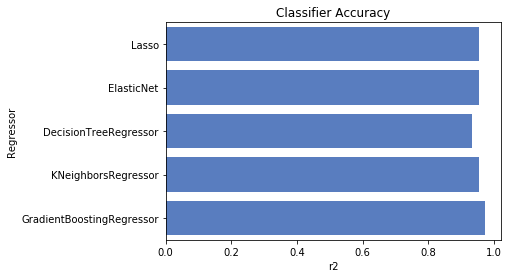

In [25]:
log_cols = ["Regressor", "r2"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for reg in regressors:
    name = reg.__class__.__name__
    
    acc = cross_validate(reg, X, y, scoring=['r2', 'neg_mean_squared_error'], cv=3, n_jobs=-1)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for reg in acc_dict:
    log_entry = pd.DataFrame([[reg, acc_dict[reg]['test_r2'].mean()]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='r2', y='Regressor', data=log, color="b")

# train gradiend boosting regressor

Вообще этот регрессор выглядит многообещающе, но я потратил на него уже три попытки и все были с отрицательным r2 -> я както неправильно подготавливаю данные. Скорее всего я где-то неправ со scaler'ом. А мб он прост не работает и не надо тратить на него время

In [47]:
X_train, X_test = X[600:], X[:600]
y_train, y_test = y[600:], y[:600]


In [42]:
gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
y_preds = gbr_reg.predict(X_test)

In [44]:
gbr_reg.score(X_test, y_test)

0.9923531001197886

In [46]:

test_set = pd.read_csv('./robot_data/test_data.csv')
years = test_set['year']

test_set = test_set.drop(columns=['year', 'target'])
test_set = simple_encode(test_set)
#print(test_set.head())
y_pred = gbr_reg.predict(test_set)
y_pred = y_pred.reshape(1000)


d = {'year': years.values, 'target': y_pred}
ans = pd.DataFrame(d)
ans = ans.set_index('year')

ans.to_csv('./submissions/subm_gbr.csv')

# Train mlp w\ dropout

In [10]:

def create_dropout_model(n_cols):
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

In [13]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 1 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               37120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
__________

2130/2130 [==============================] - 2s 708us/step - loss: 43.9992 - coeff_determination: 0.9152 - val_loss: 29.9208 - val_coeff_determination: 0.8992
Epoch 39/100
2130/2130 [==============================] - 1s 693us/step - loss: 50.9875 - coeff_determination: 0.9157 - val_loss: 35.6414 - val_coeff_determination: 0.8736
Epoch 40/100
2130/2130 [==============================] - 1s 659us/step - loss: 34.4945 - coeff_determination: 0.9275 - val_loss: 25.1863 - val_coeff_determination: 0.8976
Epoch 41/100
2130/2130 [==============================] - 1s 636us/step - loss: 37.5621 - coeff_determination: 0.9368 - val_loss: 23.4417 - val_coeff_determination: 0.8908
Epoch 42/100
2130/2130 [==============================] - 1s 653us/step - loss: 42.4230 - coeff_determination: 0.9328 - val_loss: 39.7937 - val_coeff_determination: 0.8573
Epoch 43/100
2130/2130 [==============================] - 1s 691us/step - loss: 47.1239 - coeff_determination: 0.9234 - val_loss: 63.6818 - val_coeff_det

2130/2130 [==============================] - 2s 723us/step - loss: 39.9621 - coeff_determination: 0.9131 - val_loss: 46.1296 - val_coeff_determination: 0.8437
Epoch 86/100
2130/2130 [==============================] - 2s 722us/step - loss: 26.7108 - coeff_determination: 0.9474 - val_loss: 35.6812 - val_coeff_determination: 0.8466
Epoch 87/100
2130/2130 [==============================] - 1s 698us/step - loss: 62.4814 - coeff_determination: 0.9224 - val_loss: 117.0677 - val_coeff_determination: 0.7699
Epoch 88/100
2130/2130 [==============================] - 2s 715us/step - loss: 49.3457 - coeff_determination: 0.9109 - val_loss: 33.7994 - val_coeff_determination: 0.8422
Epoch 89/100
2130/2130 [==============================] - 2s 715us/step - loss: 48.3071 - coeff_determination: 0.9195 - val_loss: 70.9535 - val_coeff_determination: 0.8584
Epoch 90/100
2130/2130 [==============================] - 2s 708us/step - loss: 108.1693 - coeff_determination: 0.8776 - val_loss: 84.9357 - val_coeff_d

In [14]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 110us/step


[31.21619177500407, 0.8982356762886048]

# exploring differences between train and test set

In [8]:
train_set = pd.read_csv('./robot_data/train_data.csv')
test_set = pd.read_csv('./robot_data/test_data.csv')

In [11]:
train_set.describe()

,year,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,...,weapon_robot_eye_laser_sensor_4,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,target
count,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,...,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000,3263.000000
mean,3650.000000,4.743382,4.711188,4.150240,0.735772,0.356302,3.980784,4.795702,3.489475,-11.762066,...,-0.314341,-1.619153,-1.227771,-0.368780,-0.966306,-0.351048,-0.102309,-3.162996,-5.764416,3.974753
std,942.091291,11.971591,12.600201,15.414344,32.491776,21.249066,11.971590,21.787280,23.439238,39.628929,...,13.785414,15.729530,15.046405,11.752485,52.007397,25.875938,19.137775,13.069460,48.923364,21.058748
min,2019.000000,-41.222606,-50.708097,-85.115629,-237.802677,-62.005399,-20.918665,-37.047343,-30.209884,-129.428980,...,-260.782205,-204.598022,-267.461044,-171.454268,-700.034237,-350.057140,-259.983389,-45.065021,-260.177848,-222.068373
25%,2834.500000,-4.347614,-5.053198,-5.476476,-11.600617,-14.192575,-3.085307,-7.531737,-7.319708,-37.700655,...,0.528241,-2.906805,-1.409485,-0.300321,3.006966,1.331924,1.089518,-12.711290,-21.939303,-6.439736
50%,3650.000000,10.982071,11.185722,12.667528,2.585477,6.194435,6.779509,10.790315,3.339351,-15.966160,...,0.813811,4.115493,2.352888,0.757984,3.105589,1.690868,1.386072,-2.944265,-2.201517,10.087139
75%,4465.500000,14.536056,15.194974,15.871684,23.110990,17.123009,11.240535,16.412493,13.688108,16.612456,...,0.956559,6.543507,4.231996,1.647482,3.193184,2.047907,1.675096,6.607371,18.228823,17.292415
max,5281.000000,16.485844,17.096144,20.793896,65.593323,126.019083,122.988116,242.904661,308.146334,112.222819,...,1.813343,17.959283,12.010494,3.795320,6.940355,4.374593,51.588361,30.050211,98.218800,25.643372


In [12]:
test_set.describe()

,year,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,...,weapon_robot_eye_laser_sensor_4,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.0
mean,5781.500000,-15.204345,-17.057074,-12.853181,-1.485488,-1.588619,-10.368659,-16.642460,-11.248558,37.500096,...,0.836646,5.246772,4.670074,0.393284,3.128842,1.366749,1.251262,9.478605,17.428577,NaN
std,288.819436,8.531025,8.193020,13.374149,40.899702,14.924284,6.329062,10.501338,9.222103,49.230480,...,0.272670,9.268219,4.177420,2.789772,0.152914,7.631009,2.555768,7.313640,29.269299,NaN
min,5282.000000,-32.526254,-34.168089,-37.484949,-72.592436,-36.684364,-25.690824,-43.105140,-33.029540,-39.218220,...,-0.042973,-49.542748,-30.534257,-61.735407,1.672578,-205.408646,-72.508802,-10.427499,-39.945705,NaN
25%,5531.750000,-21.870414,-23.309423,-23.986384,-35.095944,-13.093586,-15.101739,-24.201531,-18.025070,-4.133704,...,0.528241,4.355103,3.257936,-0.161030,3.052259,1.345816,1.104160,4.934188,-7.482240,NaN
50%,5781.500000,-15.568692,-17.390890,-13.476731,-3.207340,-2.524600,-10.475820,-16.707536,-11.709597,25.932281,...,0.813811,8.267325,5.014193,0.713371,3.132164,1.713545,1.342760,8.769917,17.363131,NaN
75%,6031.250000,-9.100485,-11.145068,-3.352189,28.521265,9.188150,-6.124118,-9.901361,-5.951914,71.458683,...,1.099381,10.446910,7.279100,1.580930,3.218121,2.056173,1.613250,14.657091,41.083102,NaN
max,6281.000000,6.686972,3.754385,20.679420,97.736415,31.882373,6.796816,12.050032,17.474836,169.914542,...,1.670558,18.097077,12.430175,3.442494,4.078944,3.841760,3.012549,28.205311,86.791661,NaN


# Predict on test set

In [16]:
def get_preds_on_test(model, enc='simple'):
    df = pd.read_csv('./robot_data/test_data.csv')
    df = df.drop(columns=['year', 'target'])
    
    if enc == 'simple':
        df = simple_encode(df.copy())
        
    elif enc == 'onehot':
        df = oneHotEncode(df.copy())
        
    y_pred = model.predict(df)
    return y_pred

# submit funcion

In [17]:
def create_submition(model, enc='simple', subm_name=None):
    df = pd.read_csv('./robot_data/test_data.csv')
    years = df['year']
    
    y_pred = get_preds_on_test(model)
    y_pred = y_pred.reshape(1000)
    
    
    d = {'year': years.values, 'target': y_pred}
    ans = pd.DataFrame(d)
    ans = ans.set_index('year')
    
    subm_name = subm_name if subm_name else 'submission_.csv'
    ans.to_csv(subm_name)

In [15]:
create_submition(model, subm_name='./submissions/subm_mlp_dropout_03.csv')

NameError: name 'create_submition' is not defined